
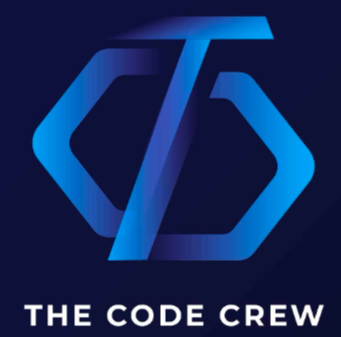


Important Dataframes and files:

- owid-covid-data.csv:This file located in the folder resources contains all the COVID Data downloaded from 
                              <a href="https://github.com/owid/covid-19-data/tree/master/public/data "> Our World in Data </a> 
- clean_covid_data:         Contains only the columns we thing we need from the covid data source csv file
- clean_covid_data_no_date: Similar to clean_covid_data. The Date in this DF now is group by Month and Year and by Country  
- df_clean_data:                 
- gdp_by_year: Iso of the countries and GDP for 2019, 2020, 221    
- covid_and_gdp: Contains a merge between gdp_by_year,df_clean_data on the ISO country
- wbdata: pulls GDP per capita data  from world bank

In [1]:
# Dependencies
import pandas as pd
import requests
import time
from matplotlib import pyplot as plt
import wbdata
from datetime import datetime 
import numpy as np 
import scipy.stats as stats

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing data from Stats Canada
csv_url = "Resources/owid-covid-data.csv"
covid_data = pd.read_csv(csv_url)


In [3]:
# Filtering DataFrame by columns of interest
clean_covid_data = covid_data.loc[covid_data['iso_code'].str.contains('OWID_')==False, ['iso_code', 'location', 'date', 'new_cases',  'new_deaths',  'new_cases_per_million',  'new_deaths_per_million',
                                      'icu_patients',
                                      'icu_patients_per_million', 'hosp_patients_per_million', 'new_tests_per_thousand',
                                      'positive_rate', 'people_vaccinated_per_hundred',
                                      'people_fully_vaccinated_per_hundred', 'stringency_index',
                                      'population_density', 'median_age',
                                      'gdp_per_capita', 'extreme_poverty', 'human_development_index', 'population']]


# Creating a list of columns to sum and calculate mean

sum_columns_list = ['new_cases',  'new_deaths',
                    'new_cases_per_million',  'new_deaths_per_million']
mean_columns_list = ['icu_patients','icu_patients_per_million','hosp_patients_per_million']                              

# Converting NaN to 0
clean_covid_data = clean_covid_data.fillna(0)

# Display DF
clean_covid_data.head(10)


,iso_code,location,date,new_cases,new_deaths,new_cases_per_million,new_deaths_per_million,icu_patients,icu_patients_per_million,hosp_patients_per_million,...,positive_rate,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,population_density,median_age,gdp_per_capita,extreme_poverty,human_development_index,population
0,AFG,Afghanistan,2020-02-24,5.0,0.0,0.122,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.33,54.422,18.6,1803.987,0.0,0.511,41128772.0
1,AFG,Afghanistan,2020-02-25,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.33,54.422,18.6,1803.987,0.0,0.511,41128772.0
2,AFG,Afghanistan,2020-02-26,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.33,54.422,18.6,1803.987,0.0,0.511,41128772.0
3,AFG,Afghanistan,2020-02-27,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.33,54.422,18.6,1803.987,0.0,0.511,41128772.0
4,AFG,Afghanistan,2020-02-28,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.33,54.422,18.6,1803.987,0.0,0.511,41128772.0
5,AFG,Afghanistan,2020-02-29,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.33,54.422,18.6,1803.987,0.0,0.511,41128772.0
6,AFG,Afghanistan,2020-03-01,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,27.78,54.422,18.6,1803.987,0.0,0.511,41128772.0
7,AFG,Afghanistan,2020-03-02,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,27.78,54.422,18.6,1803.987,0.0,0.511,41128772.0
8,AFG,Afghanistan,2020-03-03,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,27.78,54.422,18.6,1803.987,0.0,0.511,41128772.0
9,AFG,Afghanistan,2020-03-04,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,27.78,54.422,18.6,1803.987,0.0,0.511,41128772.0


In [4]:

# Creating a new column for Month-Year
clean_covid_data.insert(3,"month_year",pd.to_datetime(clean_covid_data['date']).dt.to_period('M') )
clean_covid_data_no_date = clean_covid_data.drop('date',axis = 1)

# Display DF
clean_covid_data_no_date.head(10)

,iso_code,location,month_year,new_cases,new_deaths,new_cases_per_million,new_deaths_per_million,icu_patients,icu_patients_per_million,hosp_patients_per_million,...,positive_rate,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,population_density,median_age,gdp_per_capita,extreme_poverty,human_development_index,population
0,AFG,Afghanistan,2020-02,5.0,0.0,0.122,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.33,54.422,18.6,1803.987,0.0,0.511,41128772.0
1,AFG,Afghanistan,2020-02,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.33,54.422,18.6,1803.987,0.0,0.511,41128772.0
2,AFG,Afghanistan,2020-02,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.33,54.422,18.6,1803.987,0.0,0.511,41128772.0
3,AFG,Afghanistan,2020-02,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.33,54.422,18.6,1803.987,0.0,0.511,41128772.0
4,AFG,Afghanistan,2020-02,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.33,54.422,18.6,1803.987,0.0,0.511,41128772.0
5,AFG,Afghanistan,2020-02,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.33,54.422,18.6,1803.987,0.0,0.511,41128772.0
6,AFG,Afghanistan,2020-03,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,27.78,54.422,18.6,1803.987,0.0,0.511,41128772.0
7,AFG,Afghanistan,2020-03,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,27.78,54.422,18.6,1803.987,0.0,0.511,41128772.0
8,AFG,Afghanistan,2020-03,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,27.78,54.422,18.6,1803.987,0.0,0.511,41128772.0
9,AFG,Afghanistan,2020-03,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,27.78,54.422,18.6,1803.987,0.0,0.511,41128772.0


In [5]:
iso_codes = clean_covid_data_no_date['iso_code'].unique()

In [6]:
# Creating a DataFrame grouping by Month-Year and Country and adding the columns for sums and average

df_sum = clean_covid_data_no_date.groupby(['iso_code', 'month_year'])[
    sum_columns_list].sum()

df_sum = df_sum.rename(columns={"new_cases":"sum_new_cases",'new_deaths':'sum_new_deaths', 'new_cases_per_million': 'sum_new_cases_per_million'\
                        , 'new_deaths_per_million': 'sum_new_deaths_per_million' })
                      
df_sum=df_sum.reset_index()

df_mean = clean_covid_data_no_date.groupby(['iso_code', 'month_year'])[
    mean_columns_list].mean()

df_mean=df_mean.reset_index()

df_mean = df_mean.rename(columns={'icu_patients': 'average_icu_patients',
                    'icu_patients_per_million': 'average_icu_patients_per_million','hosp_patients_per_million':'average_hosp_patients_per_million'})

df_clean_data = pd.merge(df_sum, df_mean, on=['iso_code', 'month_year'])

df_clean_data.head(10)



,iso_code,month_year,sum_new_cases,sum_new_deaths,sum_new_cases_per_million,sum_new_deaths_per_million,average_icu_patients,average_icu_patients_per_million,average_hosp_patients_per_million
0,ABW,2020-03,55.0,0.0,516.629,0.000,0.0,0.0,0.0
1,ABW,2020-04,45.0,2.0,422.698,18.786,0.0,0.0,0.0
2,ABW,2020-05,1.0,1.0,9.393,9.393,0.0,0.0,0.0
3,ABW,2020-06,2.0,0.0,18.787,0.000,0.0,0.0,0.0
4,ABW,2020-07,18.0,0.0,169.079,0.000,0.0,0.0,0.0
5,ABW,2020-08,1885.0,7.0,17706.346,65.751,0.0,0.0,0.0
6,ABW,2020-09,1957.0,17.0,18382.662,159.685,0.0,0.0,0.0
7,ABW,2020-10,550.0,12.0,5166.306,112.718,0.0,0.0,0.0
8,ABW,2020-11,332.0,7.0,3118.570,65.751,0.0,0.0,0.0
9,ABW,2020-12,644.0,4.0,6049.275,37.573,0.0,0.0,0.0


In [7]:
# Create a DataFrame for Static Columns
totals_list=['stringency_index','population_density', 'median_age',
                                      'gdp_per_capita', 'extreme_poverty', 'human_development_index', 'population']
df_totals = clean_covid_data_no_date.groupby(
    ['iso_code'])[totals_list].mean()

# Converting population to Int
df_totals['population'] = df_totals['population'].astype(int)

df_totals.head(10)


,stringency_index,population_density,median_age,gdp_per_capita,extreme_poverty,human_development_index,population
iso_code,,,,,,,
ABW,39.699157,584.800,41.2,35973.781,0.0,0.000,106459
AFG,28.103287,54.422,18.6,1803.987,0.0,0.511,41128772
AGO,53.224757,23.890,16.8,5819.495,0.0,0.581,35588996
AIA,0.000000,0.000,0.0,0.000,0.0,0.000,15877
ALB,42.891342,104.871,38.0,11803.431,1.1,0.795,2842318
AND,34.343299,163.755,0.0,0.000,0.0,0.868,79843
ARE,44.060400,112.442,34.0,67293.483,0.0,0.890,9441138
ARG,50.942899,16.177,31.9,18933.907,0.6,0.845,45510324
ARM,0.000000,102.931,35.7,8787.580,1.8,0.776,2780472


In [8]:
wbdata.getGdpData()

[{'indicator': {'id': 'NY.GDP.PCAP.CD',
   'value': 'GDP per capita (current US$)'},
  'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'},
  'countryiso3code': 'AFE',
  'date': '2021',
  'value': 1537.3360209254,
  'unit': '',
  'obs_status': '',
  'decimal': 1},
 {'indicator': {'id': 'NY.GDP.PCAP.CD',
   'value': 'GDP per capita (current US$)'},
  'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'},
  'countryiso3code': 'AFE',
  'date': '2020',
  'value': 1353.7691597287,
  'unit': '',
  'obs_status': '',
  'decimal': 1},
 {'indicator': {'id': 'NY.GDP.PCAP.CD',
   'value': 'GDP per capita (current US$)'},
  'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'},
  'countryiso3code': 'AFE',
  'date': '2019',
  'value': 1500.22927438203,
  'unit': '',
  'obs_status': '',
  'decimal': 1},
 {'indicator': {'id': 'NY.GDP.PCAP.CD',
   'value': 'GDP per capita (current US$)'},
  'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'},
  'countryiso3co

In [9]:
# Creating dataframe from World Bank API JSON
gdp = wbdata.getGdpData()
gdp = [entry for entry in gdp if int(entry['date']) > 2018]
gdp_df = pd.DataFrame.from_dict(gdp)
gdp_by_year = gdp_df[['countryiso3code', 'date', 'value']]
gdp_by_year = gdp_by_year.rename(columns={'countryiso3code': 'iso_code'})

# Fillining NaN with 0
gdp_by_year = gdp_by_year.fillna(0)

# Using .pivot_table
gdp_by_year = gdp_by_year.pivot_table(
    values='value', index='iso_code', columns='date', aggfunc='first')

gdp_by_year = gdp_by_year.reset_index()

gdp_by_year = gdp_by_year[gdp_by_year['iso_code'].isin(iso_codes)]

print(gdp_by_year)

gdp_2019 = gdp_by_year.loc[:,['iso_code', '2019']]
gdp_2019 = gdp_2019.loc[gdp_2019['2019']>0]

gdp_head = gdp_2019.sort_values(by='2019').head()
gdp_tail = gdp_2019.sort_values(by='2019').tail()

countries_selected = pd.concat([gdp_head['iso_code'], gdp_tail['iso_code']])
countries_selected = countries_selected.reset_index(drop=any).tolist()

# gdp_tail


date iso_code          2019          2020          2021
1         ABW  31650.760537  24487.863560  29342.100858
3         AFG    500.522664    516.866552    368.754614
5         AGO   2142.238757   1603.993477   1953.533757
6         ALB   5396.215864   5332.160475   6492.872012
7         AND  41327.502031  37207.493861  42137.327271
..        ...           ...           ...           ...
256       WSM   4308.272753   4042.751224   3857.318464
258       YEM      0.000000      0.000000      0.000000
259       ZAF   6688.787271   5741.643129   7055.044776
260       ZMB   1268.120941    956.831364   1137.343633
261       ZWE   1421.868596   1372.696674   1773.920411

[213 rows x 4 columns]


In [10]:
## Combining Covid Data and world bank GDP 
covid_and_gdp= pd.merge(gdp_by_year,df_clean_data, how='inner', on='iso_code')

covid_and_gdp.to_csv("Resources/covid_and_gdp.csv")

covid_and_gdp.head(10)

,iso_code,2019,2020,2021,month_year,sum_new_cases,sum_new_deaths,sum_new_cases_per_million,sum_new_deaths_per_million,average_icu_patients,average_icu_patients_per_million,average_hosp_patients_per_million
0,ABW,31650.760537,24487.86356,29342.100858,2020-03,55.0,0.0,516.629,0.000,0.0,0.0,0.0
1,ABW,31650.760537,24487.86356,29342.100858,2020-04,45.0,2.0,422.698,18.786,0.0,0.0,0.0
2,ABW,31650.760537,24487.86356,29342.100858,2020-05,1.0,1.0,9.393,9.393,0.0,0.0,0.0
3,ABW,31650.760537,24487.86356,29342.100858,2020-06,2.0,0.0,18.787,0.000,0.0,0.0,0.0
4,ABW,31650.760537,24487.86356,29342.100858,2020-07,18.0,0.0,169.079,0.000,0.0,0.0,0.0
5,ABW,31650.760537,24487.86356,29342.100858,2020-08,1885.0,7.0,17706.346,65.751,0.0,0.0,0.0
6,ABW,31650.760537,24487.86356,29342.100858,2020-09,1957.0,17.0,18382.662,159.685,0.0,0.0,0.0
7,ABW,31650.760537,24487.86356,29342.100858,2020-10,550.0,12.0,5166.306,112.718,0.0,0.0,0.0
8,ABW,31650.760537,24487.86356,29342.100858,2020-11,332.0,7.0,3118.570,65.751,0.0,0.0,0.0
9,ABW,31650.760537,24487.86356,29342.100858,2020-12,644.0,4.0,6049.275,37.573,0.0,0.0,0.0


# Histogram of the top and bottom 5 countries against new cases.

In [11]:
#getting the 5 top and bottom countries 
gdp_top = gdp_2019.sort_values(by='2019').tail(5)
gdp_bottom = gdp_2019.sort_values(by='2019').head()

# Top Countries
top_countries_selected =  gdp_top["iso_code"]
top_countries_selected=top_countries_selected.reset_index(drop=any)
print("\n The top Countries are:")
print(top_countries_selected)

# Bottom Countries
bottom_countries_selected =  gdp_bottom["iso_code"]
bottom_countries_selected=bottom_countries_selected.reset_index(drop=any)
print("\n The top Countries are:")
print(bottom_countries_selected)





 The top Countries are:
0    CYM
1    LUX
2    BMU
3    LIE
4    MCO
Name: iso_code, dtype: object

 The top Countries are:
0    BDI
1    SOM
2    CAF
3    AFG
4    SLE
Name: iso_code, dtype: object


In [12]:

# making sum_new_cases an integer
df_clean_data["sum_new_cases"] = df_clean_data["sum_new_cases"].astype("int64")
df_clean_data["sum_new_deaths"] = df_clean_data["sum_new_deaths"].astype("int64")
df_clean_data["sum_new_cases_per_million"] = df_clean_data["sum_new_cases_per_million"].astype("int64")
df_clean_data["sum_new_deaths_per_million"] = df_clean_data["sum_new_deaths_per_million"].astype("int64")

top_countries_data = df_clean_data.loc[ (df_clean_data["iso_code"].isin(top_countries_selected)),
                                        # & (df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y')=="2020"),
                                        ["iso_code","month_year","sum_new_cases"]]

# getting the month and year columns and convert them to integers in case The analysis is for every 3 months and no for every month
top_countries_data.insert(2,"year",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y'))
top_countries_data.insert(3,"month",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%m'))
top_countries_data["month"] = top_countries_data["month"].astype("int64")
top_countries_data["year"] = top_countries_data["year"].astype("int64")

top_countries_data.reset_index(drop='Any',inplace=True)

top_countries_data =top_countries_data.loc[(top_countries_data["month_year"]!= "2020-02") &
                                     (top_countries_data["month_year"]!= "2020-03") &
                                     (top_countries_data["year"]!= 2023)]

top_countries_data.head(10)


,iso_code,month_year,year,month,sum_new_cases
1,BMU,2020-04,2020,4,82
2,BMU,2020-05,2020,5,26
3,BMU,2020-06,2020,6,6
4,BMU,2020-07,2020,7,10
5,BMU,2020-08,2020,8,16
6,BMU,2020-09,2020,9,9
7,BMU,2020-10,2020,10,18
8,BMU,2020-11,2020,11,61
9,BMU,2020-12,2020,12,344
10,BMU,2021-01,2021,1,87


### Top 5 Countries - New Cases

CYM


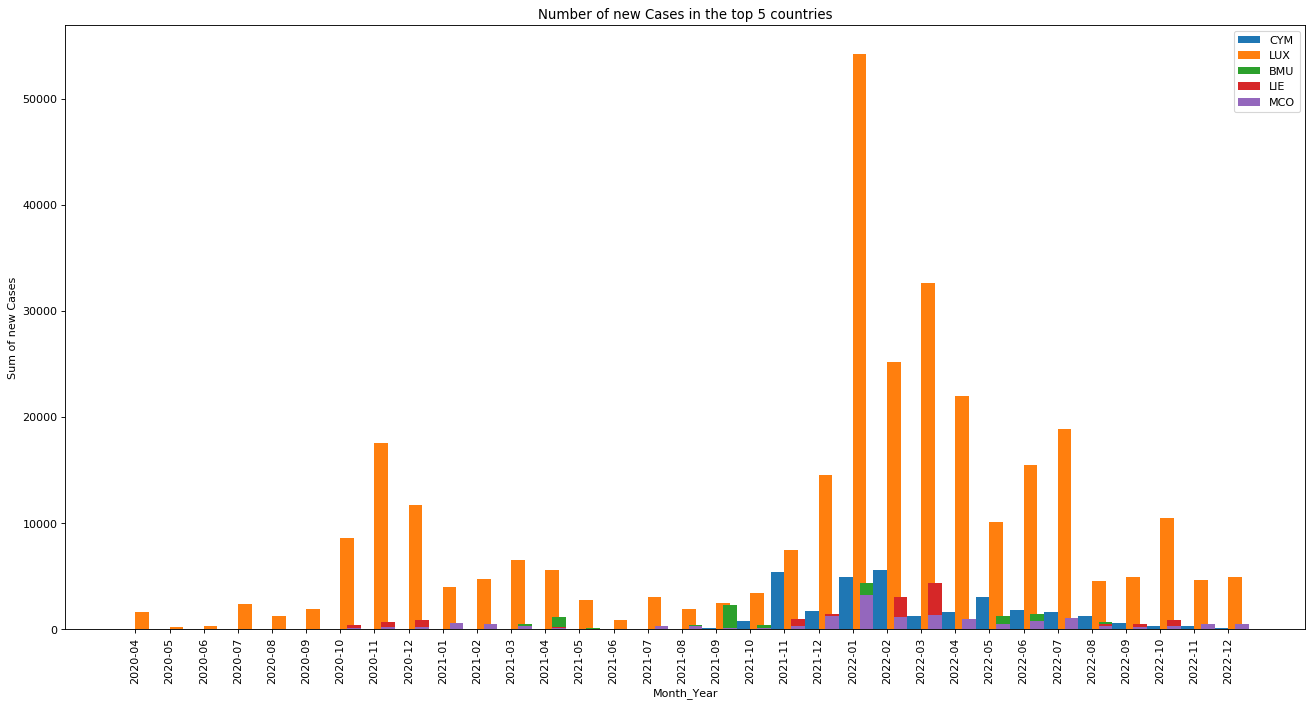

In [13]:
top_countries_data = top_countries_data.reset_index(drop=any)

labelx = []
labelx = top_countries_data["month_year"].unique()

country_1_top_sum_new_cases = top_countries_data.loc[(top_countries_data["iso_code"]==top_countries_selected[0]),["sum_new_cases"]]
country_2_top_sum_new_cases = top_countries_data.loc[(top_countries_data["iso_code"]==top_countries_selected[1]),["sum_new_cases"]]
country_3_top_sum_new_cases = top_countries_data.loc[(top_countries_data["iso_code"]==top_countries_selected[2]),["sum_new_cases"]]
country_4_top_sum_new_cases = top_countries_data.loc[(top_countries_data["iso_code"]==top_countries_selected[3]),["sum_new_cases"]]
country_5_top_sum_new_cases = top_countries_data.loc[(top_countries_data["iso_code"]==top_countries_selected[4]),["sum_new_cases"]]

country_1_top_sum_new_cases = country_1_top_sum_new_cases["sum_new_cases"].to_list()
country_2_top_sum_new_cases = country_2_top_sum_new_cases["sum_new_cases"].to_list()
country_3_top_sum_new_cases = country_3_top_sum_new_cases["sum_new_cases"].to_list()
country_4_top_sum_new_cases = country_4_top_sum_new_cases["sum_new_cases"].to_list()
country_5_top_sum_new_cases = country_5_top_sum_new_cases["sum_new_cases"].to_list()

X_axis = np.arange(len(labelx))
print(str(top_countries_selected[0]))

plt.figure(figsize=(20,10), dpi=80) 
plt.bar(X_axis - 0.2, country_1_top_sum_new_cases, 0.4, label = top_countries_selected[0])
plt.bar(X_axis + 0.2, country_2_top_sum_new_cases, 0.4, label = top_countries_selected[1])
plt.bar(X_axis + 0.4, country_3_top_sum_new_cases, 0.4, label = top_countries_selected[2])
plt.bar(X_axis + 0.4, country_4_top_sum_new_cases, 0.4, label = top_countries_selected[3])
plt.bar(X_axis + 0.4, country_5_top_sum_new_cases, 0.4, label = top_countries_selected[4])
  
plt.xticks(X_axis, labelx)
plt.xlabel("Month_Year")
plt.ylabel("Sum of new Cases")
plt.title("Number of new Cases in the top 5 countries")
plt.xticks(rotation=90)
plt.legend()
plt.show()




### Bottom 5 Countries - New Cases

In [14]:


bottom_countries_data = df_clean_data.loc[ (df_clean_data["iso_code"].isin(bottom_countries_selected)),
                                        # & (df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y')=="2020"),
                                        ["iso_code","month_year","sum_new_cases"]]




# getting the month and year columns and convert them to integers in case The analysis is for every 3 months and no for every month
bottom_countries_data.insert(2,"year",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y'))
bottom_countries_data.insert(3,"month",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%m'))
bottom_countries_data["month"] = bottom_countries_data["month"].astype("int64")
bottom_countries_data["year"] = bottom_countries_data["year"].astype("int64")

bottom_countries_data.reset_index(drop='Any',inplace=True)

bottom_countries_data =bottom_countries_data.loc[(bottom_countries_data["month_year"]!= "2020-02") &
                                     (bottom_countries_data["month_year"]!= "2020-03") &
                                     (bottom_countries_data["year"]!= 2023)]


bottom_countries_data.head()


,iso_code,month_year,year,month,sum_new_cases
2,AFG,2020-04,2020,4,1661
3,AFG,2020-05,2020,5,13353
4,AFG,2020-06,2020,6,16265
5,AFG,2020-07,2020,7,5183
6,AFG,2020-08,2020,8,1620


BDI


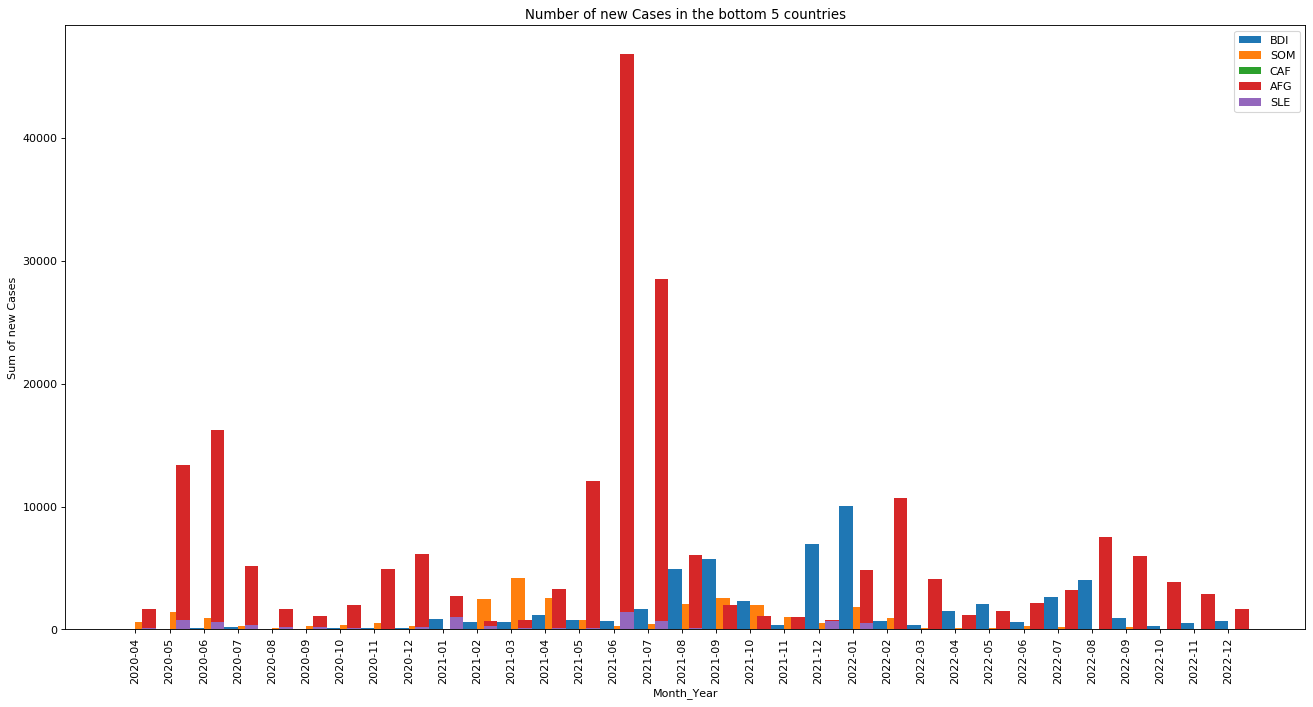

In [15]:
bottom_countries_data = bottom_countries_data.reset_index(drop=any)

labelx_b = []
labelx_b = bottom_countries_data["month_year"].unique()


country_1_bottom_sum_new_cases = bottom_countries_data.loc[(bottom_countries_data["iso_code"]==bottom_countries_selected[0]),["sum_new_cases"]]
country_2_bottom_sum_new_cases = bottom_countries_data.loc[(bottom_countries_data["iso_code"]==bottom_countries_selected[1]),["sum_new_cases"]]
country_3_bottom_sum_new_cases = bottom_countries_data.loc[(bottom_countries_data["iso_code"]==bottom_countries_selected[2]),["sum_new_cases"]]
country_4_bottom_sum_new_cases = bottom_countries_data.loc[(bottom_countries_data["iso_code"]==bottom_countries_selected[3]),["sum_new_cases"]]
country_5_bottom_sum_new_cases = bottom_countries_data.loc[(bottom_countries_data["iso_code"]==bottom_countries_selected[4]),["sum_new_cases"]]


country_1_bottom_sum_new_cases = country_1_bottom_sum_new_cases["sum_new_cases"].to_list()
country_2_bottom_sum_new_cases = country_2_bottom_sum_new_cases["sum_new_cases"].to_list()
country_3_bottom_sum_new_cases = country_3_bottom_sum_new_cases["sum_new_cases"].to_list()
country_4_bottom_sum_new_cases = country_4_bottom_sum_new_cases["sum_new_cases"].to_list()
country_5_bottom_sum_new_cases = country_5_bottom_sum_new_cases["sum_new_cases"].to_list()

X_axis = np.arange(len(labelx_b))
print(str(bottom_countries_selected[0]))

plt.figure(figsize=(20,10), dpi=80) 
plt.bar(X_axis - 0.2, country_1_bottom_sum_new_cases, 0.4, label = bottom_countries_selected[0])
plt.bar(X_axis + 0.2, country_2_bottom_sum_new_cases, 0.4, label = bottom_countries_selected[1])
plt.bar(X_axis + 0.4, country_3_bottom_sum_new_cases, 0.4, label = bottom_countries_selected[2])
plt.bar(X_axis + 0.4, country_4_bottom_sum_new_cases, 0.4, label = bottom_countries_selected[3])
plt.bar(X_axis + 0.4, country_5_bottom_sum_new_cases, 0.4, label = bottom_countries_selected[4])
  
plt.xticks(X_axis, labelx_b)
plt.xlabel("Month_Year")
plt.ylabel("Sum of new Cases")
plt.title("Number of new Cases in the bottom 5 countries")
plt.xticks(rotation=90)
plt.legend()
plt.show()





# Histogram of the top and bottom 5 countries against number of deaths

In [16]:



top_countries_data_deaths = df_clean_data.loc[ (df_clean_data["iso_code"].isin(top_countries_selected)),
                                        # & (df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y')=="2020"),
                                        ["iso_code","month_year","sum_new_deaths"]]




# getting the month and year columns and convert them to integers in case The analysis is for every 3 months and no for every month
top_countries_data_deaths.insert(2,"year",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y'))
top_countries_data_deaths.insert(3,"month",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%m'))
top_countries_data_deaths["month"] = top_countries_data_deaths["month"].astype("int64")
top_countries_data_deaths["year"] = top_countries_data_deaths["year"].astype("int64")

top_countries_data_deaths.reset_index(drop='Any',inplace=True)

top_countries_data_deaths =top_countries_data_deaths.loc[(top_countries_data_deaths["month_year"]!= "2020-02") &
                                     (top_countries_data_deaths["month_year"]!= "2020-03") &
                                     (top_countries_data_deaths["year"]!= 2023)]


top_countries_data_deaths.head()



,iso_code,month_year,year,month,sum_new_deaths
1,BMU,2020-04,2020,4,6
2,BMU,2020-05,2020,5,3
3,BMU,2020-06,2020,6,0
4,BMU,2020-07,2020,7,0
5,BMU,2020-08,2020,8,0


### Top 5 Countries - New Deaths

CYM


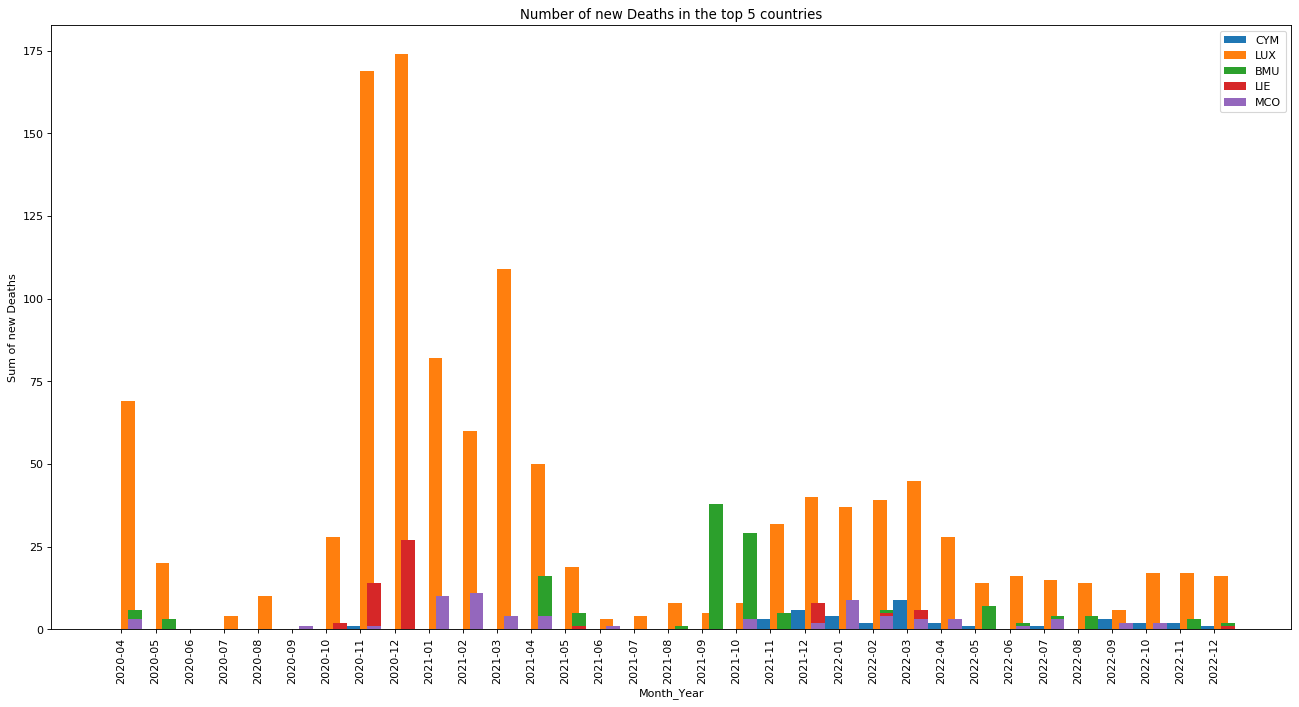

In [17]:

top_countries_data_deaths = top_countries_data_deaths.reset_index(drop=any)

labelx_dt = []
labelx_dt = top_countries_data_deaths["month_year"].unique()


country_1_top_sum_new_deaths = top_countries_data_deaths.loc[(top_countries_data_deaths["iso_code"]==top_countries_selected[0]),["sum_new_deaths"]]
country_2_top_sum_new_deaths = top_countries_data_deaths.loc[(top_countries_data_deaths["iso_code"]==top_countries_selected[1]),["sum_new_deaths"]]
country_3_top_sum_new_deaths = top_countries_data_deaths.loc[(top_countries_data_deaths["iso_code"]==top_countries_selected[2]),["sum_new_deaths"]]
country_4_top_sum_new_deaths = top_countries_data_deaths.loc[(top_countries_data_deaths["iso_code"]==top_countries_selected[3]),["sum_new_deaths"]]
country_5_top_sum_new_deaths = top_countries_data_deaths.loc[(top_countries_data_deaths["iso_code"]==top_countries_selected[4]),["sum_new_deaths"]]


country_1_top_sum_new_deaths = country_1_top_sum_new_deaths["sum_new_deaths"].to_list()
country_2_top_sum_new_deaths = country_2_top_sum_new_deaths["sum_new_deaths"].to_list()
country_3_top_sum_new_deaths = country_3_top_sum_new_deaths["sum_new_deaths"].to_list()
country_4_top_sum_new_deaths = country_4_top_sum_new_deaths["sum_new_deaths"].to_list()
country_5_top_sum_new_deaths = country_5_top_sum_new_deaths["sum_new_deaths"].to_list()

X_axis = np.arange(len(labelx_dt))
print(str(top_countries_selected[0]))

plt.figure(figsize=(20,10), dpi=80) 
plt.bar(X_axis - 0.2, country_1_top_sum_new_deaths, 0.4, label = top_countries_selected[0])
plt.bar(X_axis + 0.2, country_2_top_sum_new_deaths, 0.4, label = top_countries_selected[1])
plt.bar(X_axis + 0.4, country_3_top_sum_new_deaths, 0.4, label = top_countries_selected[2])
plt.bar(X_axis + 0.4, country_4_top_sum_new_deaths, 0.4, label = top_countries_selected[3])
plt.bar(X_axis + 0.4, country_5_top_sum_new_deaths, 0.4, label = top_countries_selected[4])
  
plt.xticks(X_axis, labelx)
plt.xlabel("Month_Year")
plt.ylabel("Sum of new Deaths")
plt.title("Number of new Deaths in the top 5 countries")
plt.xticks(rotation=90)
plt.legend()
plt.show()



### Bottom 5 Countries - New Deaths

In [18]:
bottom_countries_data_deaths = df_clean_data.loc[ (df_clean_data["iso_code"].isin(bottom_countries_selected)),
                                        # & (df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y')=="2020"),
                                        ["iso_code","month_year","sum_new_deaths"]]




# getting the month and year columns and convert them to integers in case The analysis is for every 3 months and no for every month
bottom_countries_data_deaths.insert(2,"year",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y'))
bottom_countries_data_deaths.insert(3,"month",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%m'))
bottom_countries_data_deaths["month"] = bottom_countries_data_deaths["month"].astype("int64")
bottom_countries_data_deaths["year"] = bottom_countries_data_deaths["year"].astype("int64")

bottom_countries_data_deaths.reset_index(drop='Any',inplace=True)

bottom_countries_data_deaths =bottom_countries_data_deaths.loc[(bottom_countries_data_deaths["month_year"]!= "2020-02") &
                                     (bottom_countries_data_deaths["month_year"]!= "2020-03") &
                                     (bottom_countries_data_deaths["year"]!= 2023)]


bottom_countries_data_deaths


,iso_code,month_year,year,month,sum_new_deaths
2,AFG,2020-04,2020,4,56
3,AFG,2020-05,2020,5,194
4,AFG,2020-06,2020,6,485
5,AFG,2020-07,2020,7,536
6,AFG,2020-08,2020,8,131
...,...,...,...,...,...
174,SOM,2022-08,2022,8,0
175,SOM,2022-09,2022,9,0
176,SOM,2022-10,2022,10,0
177,SOM,2022-11,2022,11,0


BDI


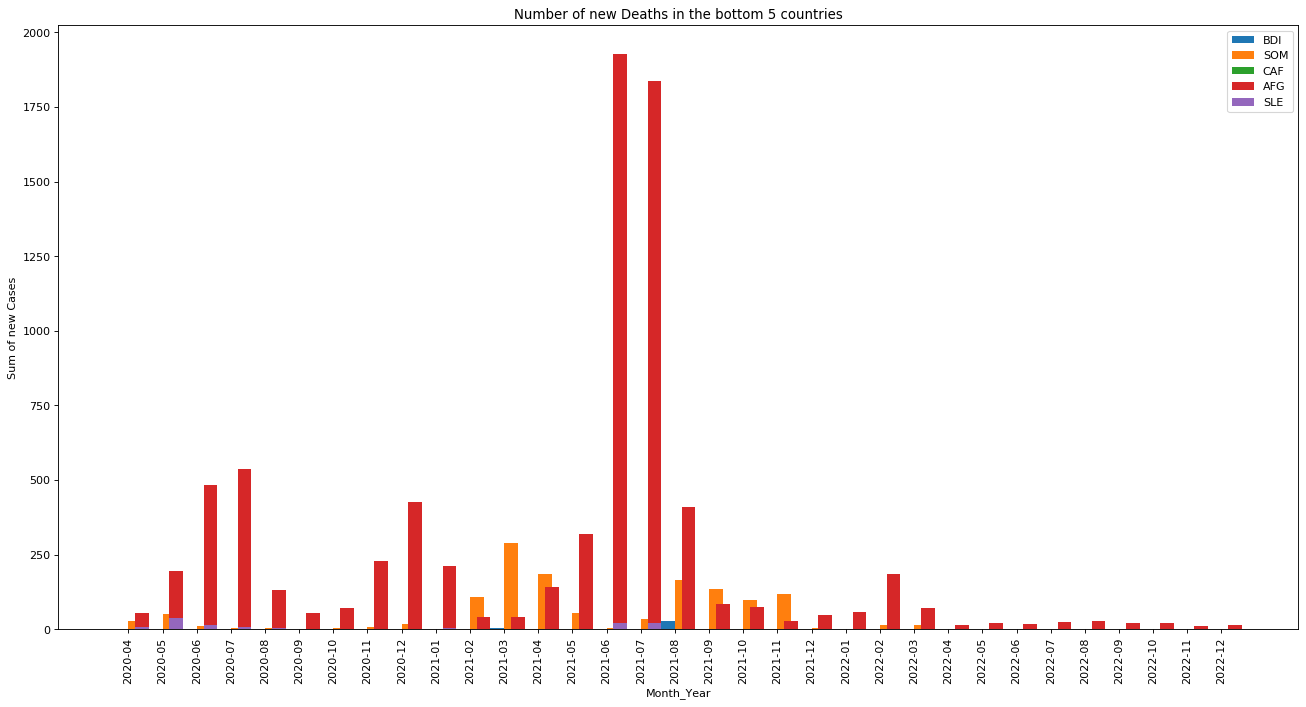

In [19]:
bottom_countries_data_deaths = bottom_countries_data_deaths.reset_index(drop=any)

labelx_bd = []
labelx_bd = bottom_countries_data_deaths["month_year"].unique()


country_1_bottom_sum_new_deaths = bottom_countries_data_deaths.loc[(bottom_countries_data_deaths["iso_code"]==bottom_countries_selected[0]),["sum_new_deaths"]]
country_2_bottom_sum_new_deaths = bottom_countries_data_deaths.loc[(bottom_countries_data_deaths["iso_code"]==bottom_countries_selected[1]),["sum_new_deaths"]]
country_3_bottom_sum_new_deaths = bottom_countries_data_deaths.loc[(bottom_countries_data_deaths["iso_code"]==bottom_countries_selected[2]),["sum_new_deaths"]]
country_4_bottom_sum_new_deaths = bottom_countries_data_deaths.loc[(bottom_countries_data_deaths["iso_code"]==bottom_countries_selected[3]),["sum_new_deaths"]]
country_5_bottom_sum_new_deaths = bottom_countries_data_deaths.loc[(bottom_countries_data_deaths["iso_code"]==bottom_countries_selected[4]),["sum_new_deaths"]]


country_1_bottom_sum_new_deaths = country_1_bottom_sum_new_deaths["sum_new_deaths"].to_list()
country_2_bottom_sum_new_deaths = country_2_bottom_sum_new_deaths["sum_new_deaths"].to_list()
country_3_bottom_sum_new_deaths = country_3_bottom_sum_new_deaths["sum_new_deaths"].to_list()
country_4_bottom_sum_new_deaths = country_4_bottom_sum_new_deaths["sum_new_deaths"].to_list()
country_5_bottom_sum_new_deaths = country_5_bottom_sum_new_deaths["sum_new_deaths"].to_list()

X_axis = np.arange(len(labelx_bd))
print(str(bottom_countries_selected[0]))

plt.figure(figsize=(20,10), dpi=80) 
plt.bar(X_axis - 0.2, country_1_bottom_sum_new_deaths, 0.4, label = bottom_countries_selected[0])
plt.bar(X_axis + 0.2, country_2_bottom_sum_new_deaths, 0.4, label = bottom_countries_selected[1])
plt.bar(X_axis + 0.4, country_3_bottom_sum_new_deaths, 0.4, label = bottom_countries_selected[2])
plt.bar(X_axis + 0.4, country_4_bottom_sum_new_deaths, 0.4, label = bottom_countries_selected[3])
plt.bar(X_axis + 0.4, country_5_bottom_sum_new_deaths, 0.4, label = bottom_countries_selected[4])
  
plt.xticks(X_axis, labelx_b)
plt.xlabel("Month_Year")
plt.ylabel("Sum of new Cases")
plt.title("Number of new Deaths in the bottom 5 countries")
plt.xticks(rotation=90)
plt.legend()
plt.show()



# Sample Data
## Line graph comparing cases progression and stringency

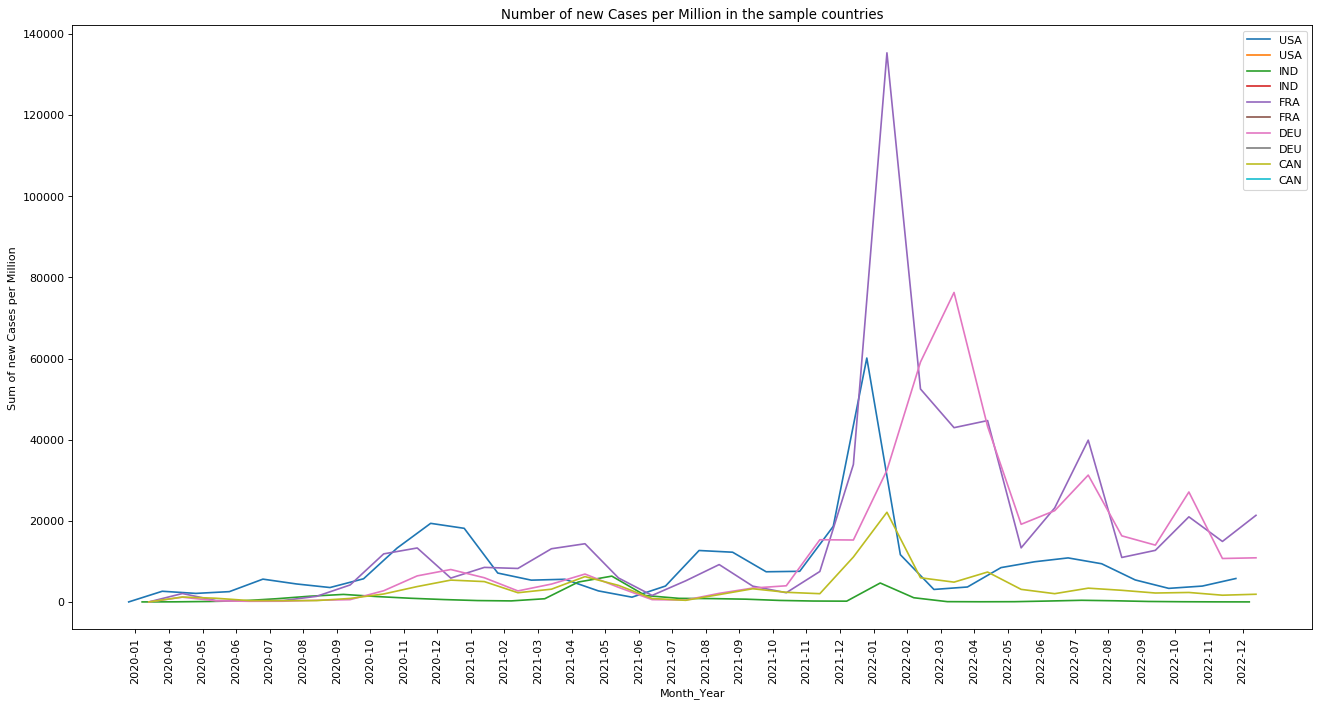

In [20]:

# creating sample countries list
sample_countries = ['USA','IND','FRA','DEU','CAN']
sample_clean_world = df_clean_data.loc[ (df_clean_data["iso_code"].isin(sample_countries)),["iso_code","month_year","sum_new_cases_per_million"]]



# getting the month and year columns and convert them to integers in case The analysis is for every 3 months and no for every month
sample_clean_world.insert(2,"year",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%Y'))
sample_clean_world.insert(3,"month",df_clean_data['month_year'].dt.to_timestamp().dt.strftime('%m'))
sample_clean_world["month"] = sample_clean_world["month"].astype("int64")
sample_clean_world["year"] = sample_clean_world["year"].astype("int64")


sample_clean_world.reset_index(drop='Any',inplace=True)


sample_clean_world =sample_clean_world.loc[(sample_clean_world["month_year"]!= "2020-02") &
                                     (sample_clean_world["month_year"]!= "2020-03") &
                                     (sample_clean_world["year"]!= 2023)]


sample_clean_world = sample_clean_world.reset_index(drop=any)



labelx_b = []
labelx_b = sample_clean_world["month_year"].unique()

stringency_index1 = sample_clean_world.loc[(sample_clean_world["iso_code"]==sample_countries[0]),["sum_new_cases_per_million"]]
stringency_index2 = sample_clean_world.loc[(sample_clean_world["iso_code"]==sample_countries[1]),["sum_new_cases_per_million"]]
stringency_index3 = sample_clean_world.loc[(sample_clean_world["iso_code"]==sample_countries[2]),["sum_new_cases_per_million"]]
stringency_index4 = sample_clean_world.loc[(sample_clean_world["iso_code"]==sample_countries[3]),["sum_new_cases_per_million"]]
stringency_index5 = sample_clean_world.loc[(sample_clean_world["iso_code"]==sample_countries[4]),["sum_new_cases_per_million"]]


stringency_index1 = stringency_index1["sum_new_cases_per_million"].to_list()
stringency_index2 = stringency_index2["sum_new_cases_per_million"].to_list()
stringency_index3 = stringency_index3["sum_new_cases_per_million"].to_list()
stringency_index4 = stringency_index4["sum_new_cases_per_million"].to_list()
stringency_index5 = stringency_index5["sum_new_cases_per_million"].to_list()

X_axis = np.arange(len(labelx_b))

# plotting line graph with sample total cases per million 

plt.figure(figsize=(20,10), dpi=80) 
plt.plot(X_axis - 0.2, stringency_index1, 0.4, label = sample_countries[0])
plt.plot(X_axis + 0.2, stringency_index2, 0.4, label = sample_countries[1])
plt.plot(X_axis + 0.4, stringency_index3, 0.4, label = sample_countries[2])
plt.plot(X_axis + 0.4, stringency_index4, 0.4, label = sample_countries[3])
plt.plot(X_axis + 0.4, stringency_index5, 0.4, label = sample_countries[4])
  
plt.xticks(X_axis, labelx_b)
plt.xlabel("Month_Year")
plt.ylabel("Sum of new Cases per Million")
plt.title("Number of new Cases per Million in the sample countries")
plt.xticks(rotation=90)
plt.legend()
plt.show()


Text(0.5, 1.0, 'Stringency Index by Month in Sample Countries')

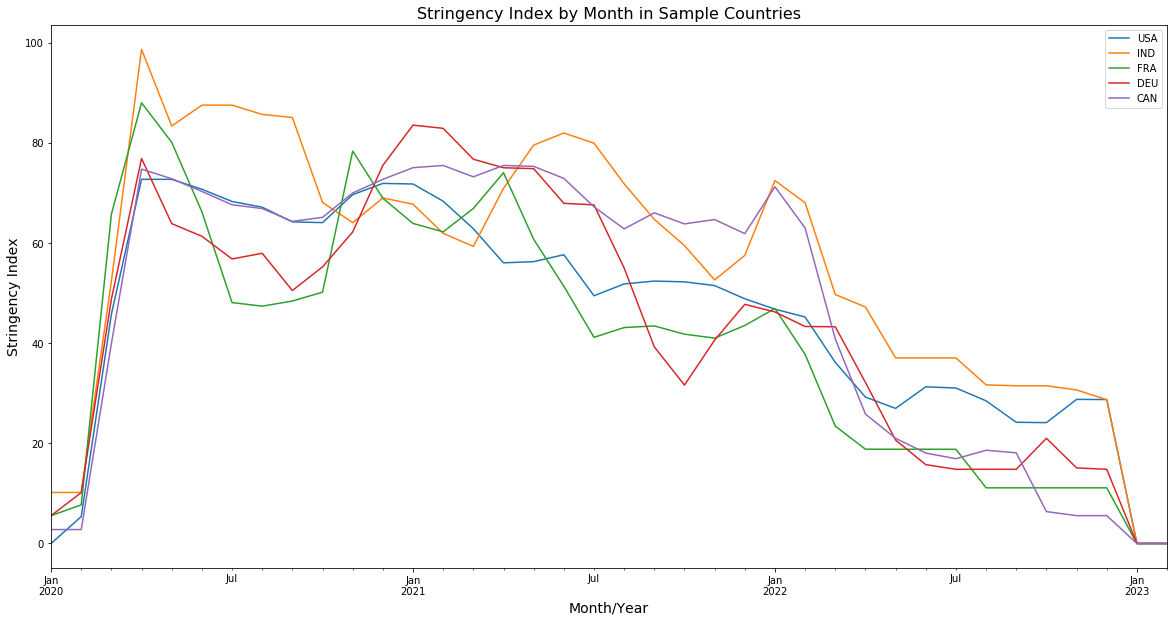

In [21]:
sample_countries = ['USA','IND','FRA','DEU','CAN']

# getting stringency index data
df_stringency = clean_covid_data_no_date.groupby(['iso_code', 'month_year'])[
    ['stringency_index']].mean()

df_stringency = df_stringency.reset_index()
df_stringency1 = df_stringency[df_stringency['iso_code']==sample_countries[0]]
df_stringency2 = df_stringency[df_stringency['iso_code']==sample_countries[1]]
df_stringency3 = df_stringency[df_stringency['iso_code']==sample_countries[2]]
df_stringency4 = df_stringency[df_stringency['iso_code']==sample_countries[3]]
df_stringency5 = df_stringency[df_stringency['iso_code']==sample_countries[4]]

# plotting sample countries stringency index

ax = df_stringency1.plot(x='month_year',y='stringency_index', label=sample_countries[0],figsize=(20,10))
df_stringency2.plot(ax=ax,x='month_year',y='stringency_index', label=sample_countries[1])
df_stringency3.plot(ax=ax,x='month_year',y='stringency_index', label=sample_countries[2])
df_stringency4.plot(ax=ax,x='month_year',y='stringency_index', label=sample_countries[3])
df_stringency5.plot(ax=ax,x='month_year',y='stringency_index', label=sample_countries[4])
ax.set_ylabel("Stringency Index", fontsize = 14)
ax.set_xlabel("Month/Year", fontsize = 14)
ax.set_ylabel("Stringency Index", fontsize = 14)
ax.set_title(f"Stringency Index by Month in Sample Countries", fontsize = 16)

Text(0.5, 1.0, 'New Cases per Million Sample Countries')

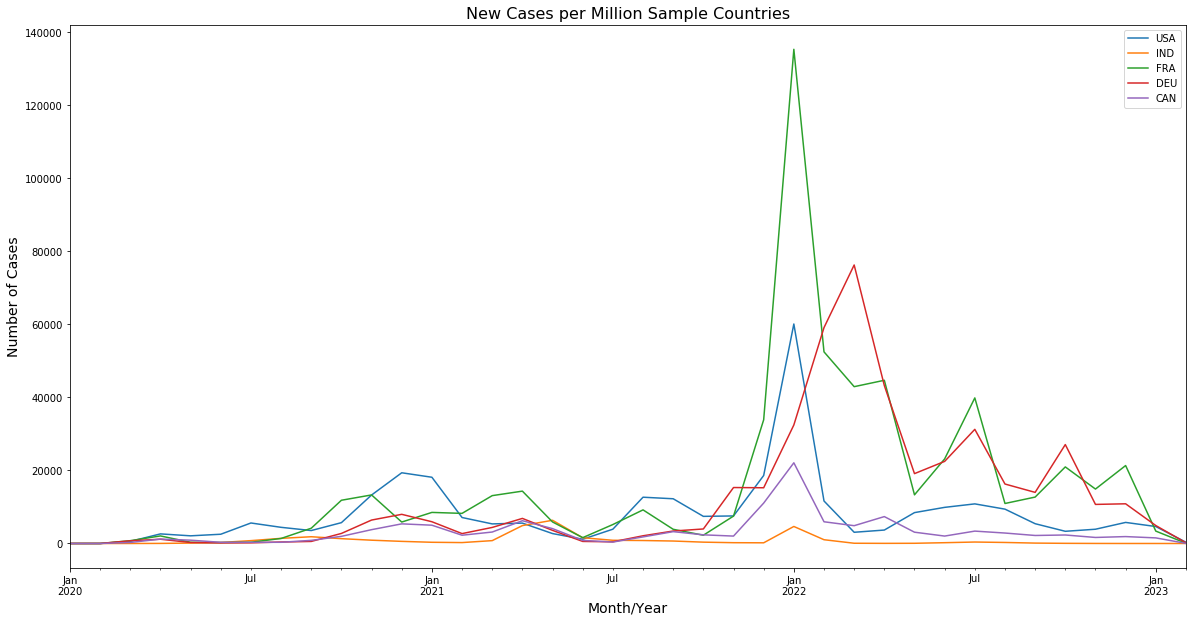

In [22]:
df_sum_cases_million = clean_covid_data_no_date.groupby(['iso_code', 'month_year'])[
    ['new_cases_per_million']].sum()
df_sum_cases_million = df_sum_cases_million.rename(columns={'new_cases_per_million': 'sum_new_cases_per_million'})

df_sum_cases_million = df_sum_cases_million.reset_index()

df_sum_cases_million1 = df_sum_cases_million[df_sum_cases_million['iso_code']==sample_countries[0]]
df_sum_cases_million2 = df_sum_cases_million[df_sum_cases_million['iso_code']==sample_countries[1]]
df_sum_cases_million3 = df_sum_cases_million[df_sum_cases_million['iso_code']==sample_countries[2]]
df_sum_cases_million4 = df_sum_cases_million[df_sum_cases_million['iso_code']==sample_countries[3]]
df_sum_cases_million5 = df_sum_cases_million[df_sum_cases_million['iso_code']==sample_countries[4]]



ax = df_sum_cases_million1.plot(x='month_year',y='sum_new_cases_per_million', label=sample_countries[0],figsize=(20,10))
df_sum_cases_million2.plot(ax=ax,x='month_year',y='sum_new_cases_per_million', label=sample_countries[1])
df_sum_cases_million3.plot(ax=ax,x='month_year',y='sum_new_cases_per_million', label=sample_countries[2])
df_sum_cases_million4.plot(ax=ax,x='month_year',y='sum_new_cases_per_million', label=sample_countries[3])
df_sum_cases_million5.plot(ax=ax,x='month_year',y='sum_new_cases_per_million', label=sample_countries[4])
ax.set_ylabel("Sum of New Cases per Million", fontsize = 14)
ax.set_xlabel("Month/Year", fontsize = 14)
ax.set_ylabel("Number of Cases", fontsize = 14)
ax.set_title(f"New Cases per Million Sample Countries", fontsize = 16)

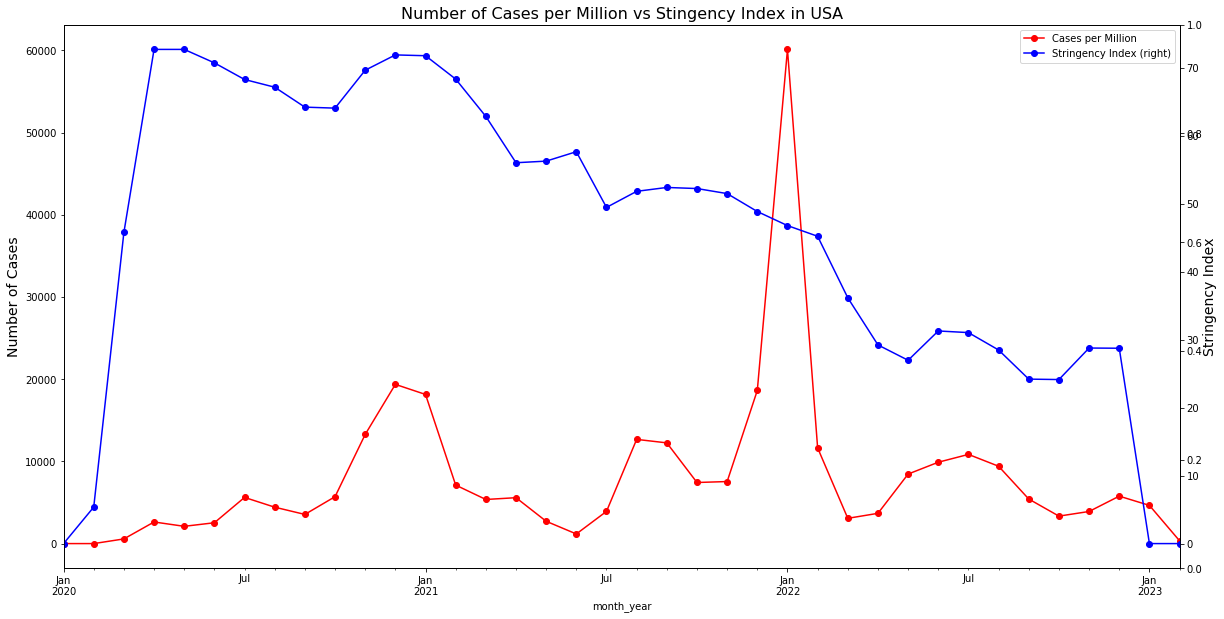

In [23]:

fig,ax = plt.subplots(figsize=(20,10))
ax = df_sum_cases_million1.plot(x = 'month_year',  y='sum_new_cases_per_million',ax = ax,
        color="red", 
        marker="o", label="Cases per Million")
ax.set_ylabel("Number of Cases", fontsize = 14)
ax2=ax.twinx()
ax2 = df_stringency1.plot(x = 'month_year',  y='stringency_index',ax = ax, secondary_y = True,
        color="blue", 
        marker="o", label="Stringency Index")
ax2.set_ylabel("Number of Cases", fontsize = 14)
ax2.set_xlabel("Month/Year", fontsize = 14)
ax2.set_ylabel("Number of Cases", fontsize = 14)
ax2.set_ylabel("Stringency Index", fontsize = 14)
ax2.set_title(f"Number of Cases per Million vs Stingency Index in {sample_countries[0]}", fontsize = 16)

plt.show()

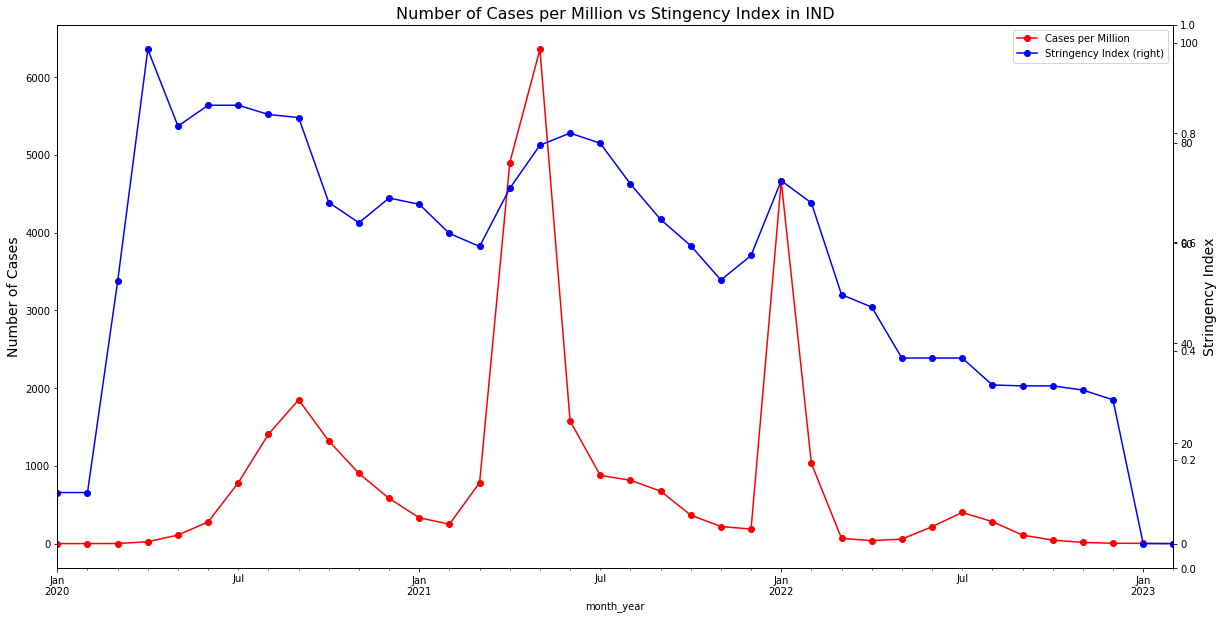

In [24]:
fig,ax = plt.subplots(figsize=(20,10))
ax = df_sum_cases_million2.plot(x = 'month_year',  y='sum_new_cases_per_million',ax = ax,
        color="red", 
        marker="o", label="Cases per Million")
ax.set_ylabel("Number of Cases", fontsize = 14)
ax2=ax.twinx()
ax2 = df_stringency2.plot(x = 'month_year',  y='stringency_index',ax = ax, secondary_y = True,
        color="blue", 
        marker="o", label="Stringency Index")
ax2.set_ylabel("Number of Cases", fontsize = 14)
ax2.set_xlabel("Month/Year", fontsize = 14)
ax2.set_ylabel("Number of Cases", fontsize = 14)
ax2.set_ylabel("Stringency Index", fontsize = 14)
ax2.set_title(f"Number of Cases per Million vs Stingency Index in {sample_countries[1]}", fontsize = 16)

plt.show()

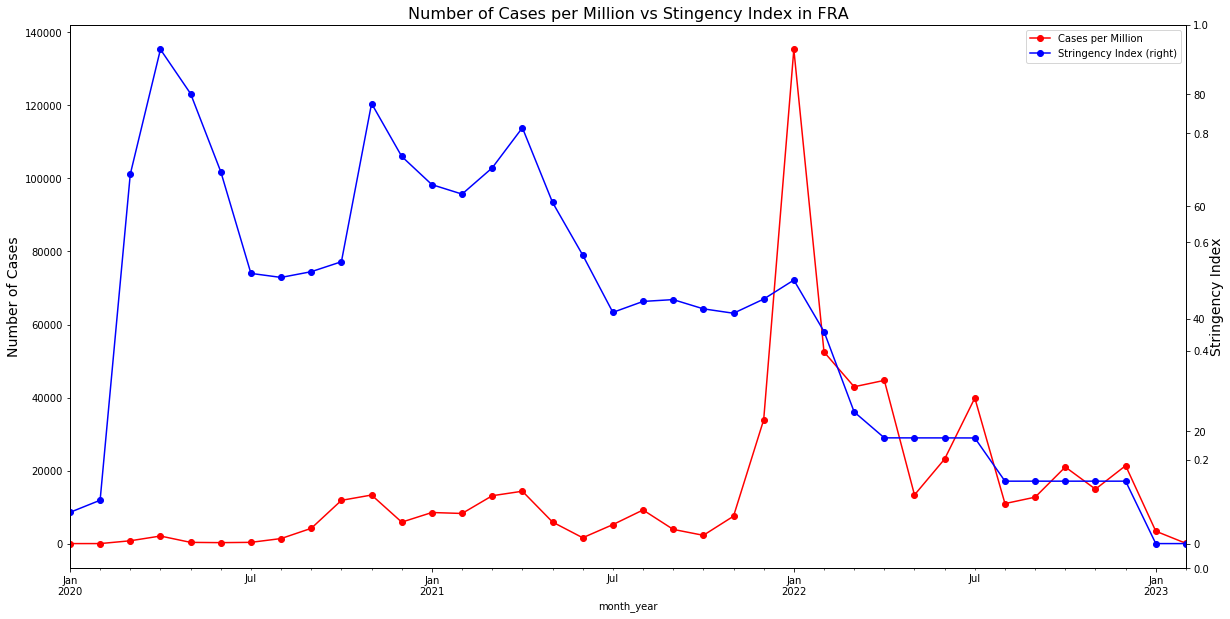

In [25]:
fig,ax = plt.subplots(figsize=(20,10))
ax = df_sum_cases_million3.plot(x = 'month_year',  y='sum_new_cases_per_million',ax = ax,
        color="red", 
        marker="o", label="Cases per Million")
ax.set_ylabel("Number of Cases", fontsize = 14)
ax2=ax.twinx()
ax2 = df_stringency3.plot(x = 'month_year',  y='stringency_index',ax = ax, secondary_y = True,
        color="blue", 
        marker="o", label="Stringency Index")
ax2.set_ylabel("Number of Cases", fontsize = 14)
ax2.set_xlabel("Month/Year", fontsize = 14)
ax2.set_ylabel("Number of Cases", fontsize = 14)
ax2.set_ylabel("Stringency Index", fontsize = 14)
ax2.set_title(f"Number of Cases per Million vs Stingency Index in {sample_countries[2]}", fontsize = 16)

plt.show()

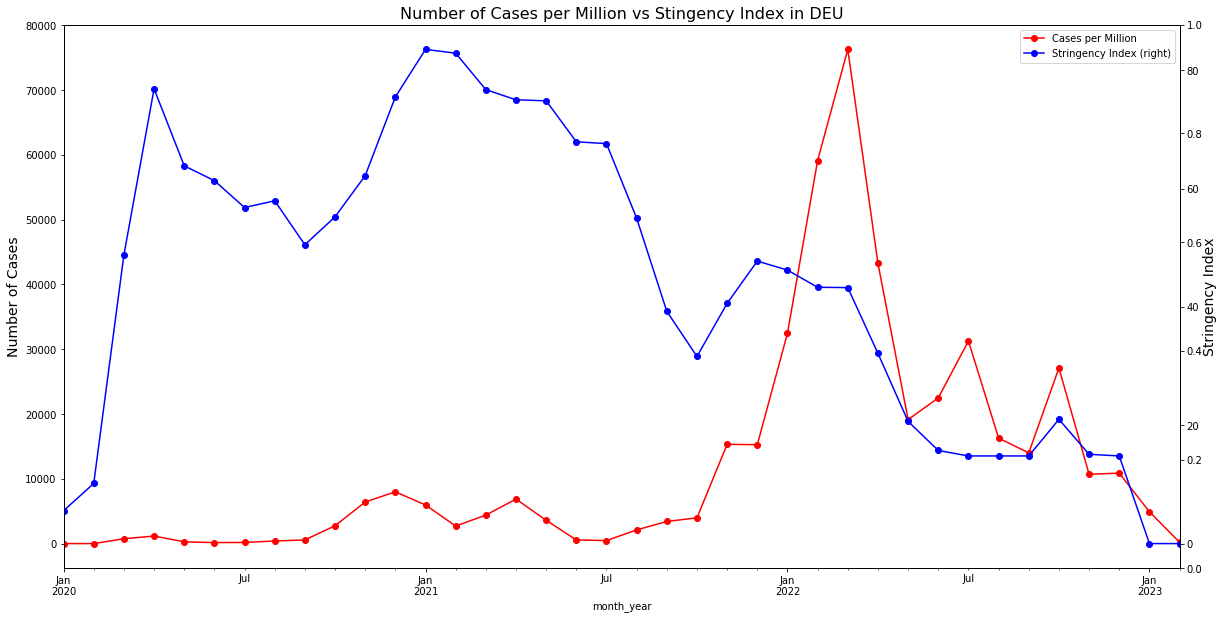

In [26]:
fig,ax = plt.subplots(figsize=(20,10))
ax = df_sum_cases_million4.plot(x = 'month_year',  y='sum_new_cases_per_million',ax = ax,
        color="red", 
        marker="o", label="Cases per Million")
ax.set_ylabel("Number of Cases", fontsize = 14)
ax2=ax.twinx()
ax2 = df_stringency4.plot(x = 'month_year',  y='stringency_index',ax = ax, secondary_y = True,
        color="blue", 
        marker="o", label="Stringency Index")
ax2.set_ylabel("Number of Cases", fontsize = 14)
ax2.set_xlabel("Month/Year", fontsize = 14)
ax2.set_ylabel("Number of Cases", fontsize = 14)
ax2.set_ylabel("Stringency Index", fontsize = 14)
ax2.set_title(f"Number of Cases per Million vs Stingency Index in {sample_countries[3]}", fontsize = 16)

plt.show()

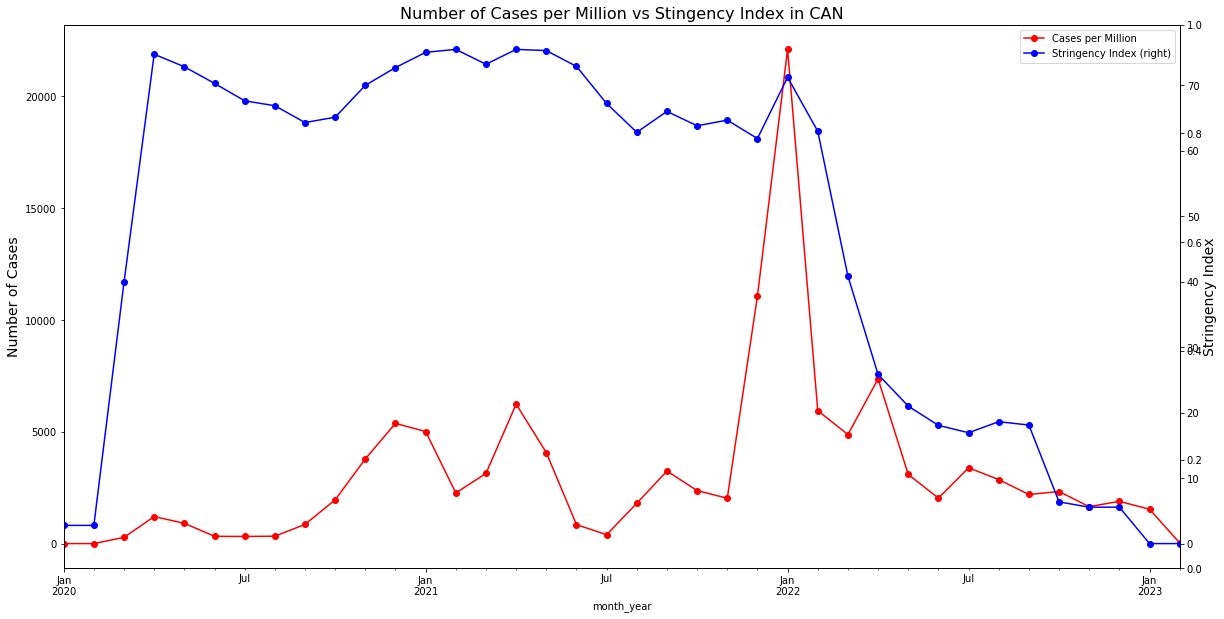

In [27]:
fig,ax = plt.subplots(figsize=(20,10))
ax = df_sum_cases_million5.plot(x = 'month_year',  y='sum_new_cases_per_million',ax = ax,
        color="red", 
        marker="o", label="Cases per Million")
ax.set_ylabel("Number of Cases", fontsize = 14)
ax2=ax.twinx()
ax2 = df_stringency5.plot(x = 'month_year',  y='stringency_index',ax = ax, secondary_y = True,
        color="blue", 
        marker="o", label="Stringency Index")
ax2.set_ylabel("Number of Cases", fontsize = 14)
ax2.set_xlabel("Month/Year", fontsize = 14)
ax2.set_ylabel("Number of Cases", fontsize = 14)
ax2.set_ylabel("Stringency Index", fontsize = 14)
ax2.set_title(f"Number of Cases per Million vs Stingency Index in {sample_countries[4]}", fontsize = 16)

plt.show()

In [28]:
# Stats for Deaths Top vs Bottom GDP
population1 = top_countries_data_deaths.groupby('month_year')['sum_new_deaths'].mean().reset_index(drop=any)
population2 = bottom_countries_data_deaths.groupby('month_year')['sum_new_deaths'].mean().reset_index(drop=any)

# Calculating PVALUE
stats.ttest_ind(population1, population2, equal_var=False)

Ttest_indResult(statistic=-3.027179687029633, pvalue=0.004785686708112386)

In [42]:
# Stats for Cases vs Stringency Index
df_stringency_pop = df_stringency.reset_index(drop=any)
df_stringency_pop = df_stringency_pop.loc[df_stringency_pop['iso_code'].isin(sample_countries)]
df_stringency_pop = pd.merge(df_stringency_pop, df_sum_cases_million, on=['iso_code', 'month_year'])
country_1 = df_stringency_pop.sort_values(by='stringency_index').head(1)['iso_code'].to_list()
country_2 = df_stringency_pop.sort_values(by='stringency_index').tail(1)['iso_code'].to_list()

population3 = df_stringency_pop.loc[df_stringency_pop['iso_code']==country_1[0]]['sum_new_cases_per_million']
population4 = df_stringency_pop.loc[df_stringency_pop['iso_code']==country_2[0]]['sum_new_cases_per_million']

# Calculating PVALUE
stats.ttest_ind(population3, population4, equal_var=False)

Ttest_indResult(statistic=4.3315265500296585, pvalue=0.00010234781408566989)